<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S3_FaceAlignment/trail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys, cv2,dlib, time
import numpy as np
import faceblendcommon as fbc
import matplotlib.pyplot as plt

In [63]:
img2 = cv2.imread('/content/banner.jpg')
img1 = cv2.imread('//content/rahul-gandhi-final-1583836570.jpg')

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

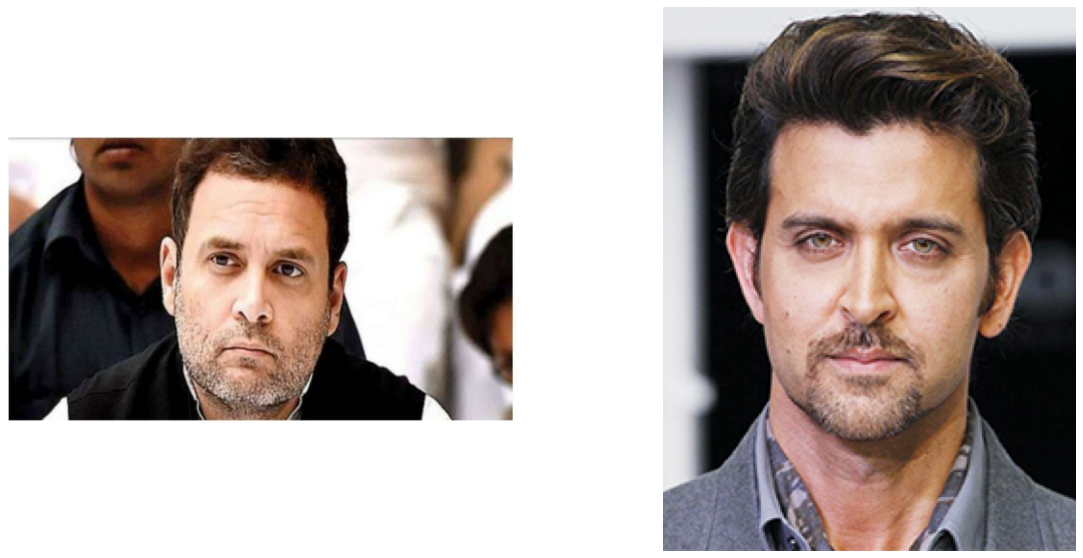

In [64]:
plt.figure(figsize = (20,10))
plt.subplot(121); plt.imshow(im1Display); plt.axis('off');
plt.subplot(122); plt.imshow(im2Display); plt.axis('off');


In [65]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2020-08-12 17:51:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.4’

shape_predictor_68_ 100%[===================>]  61.07M  3.41MB/s    in 9.7s    

2020-08-12 17:51:18 (6.29 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.4’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [66]:


# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)

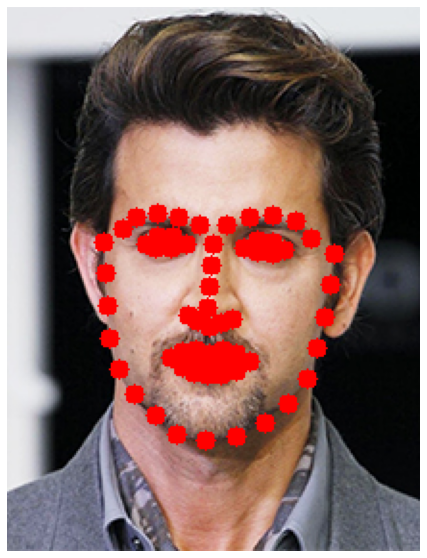

In [67]:
# Display Landmarks
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [68]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

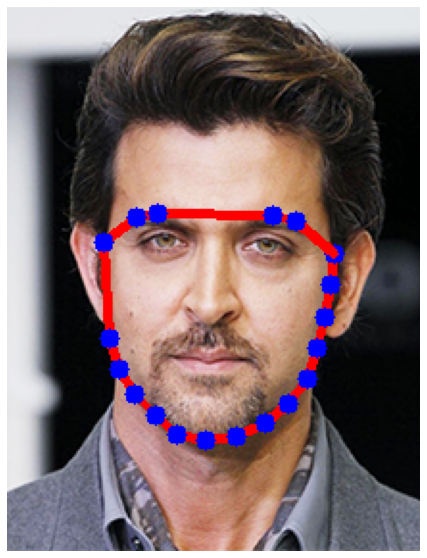

In [69]:
# Display Convex Hull
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(imTemp, hull2[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [70]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

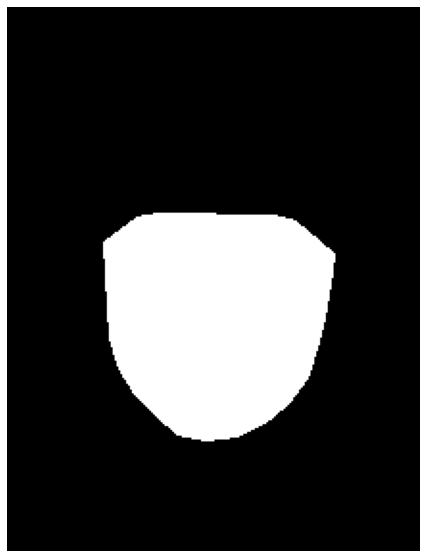

In [71]:
# Display Mask
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

In [72]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [73]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),2);
cv2.polylines(imTemp2,np.array(tris2),True,(0,0,255),2);

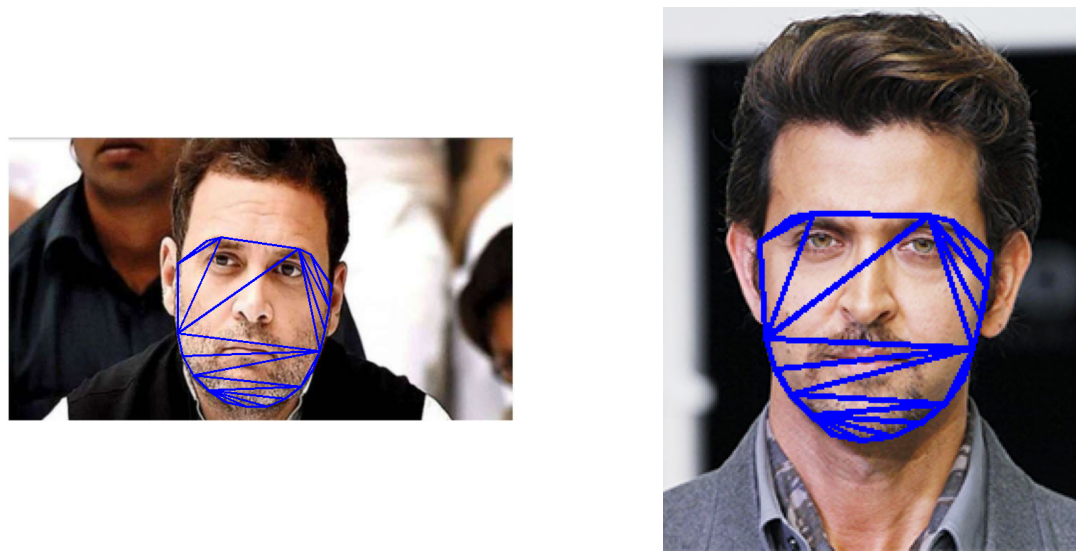

In [74]:
# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

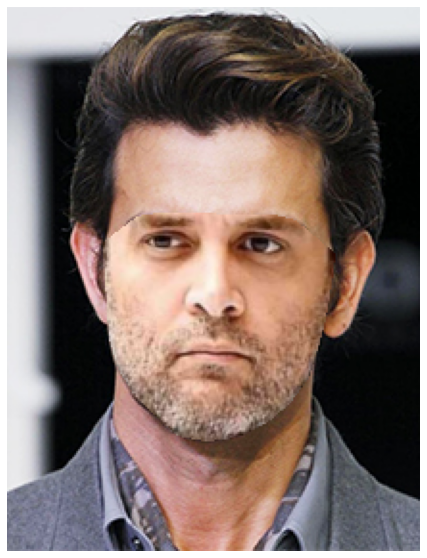

In [75]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    fbc.warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [76]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

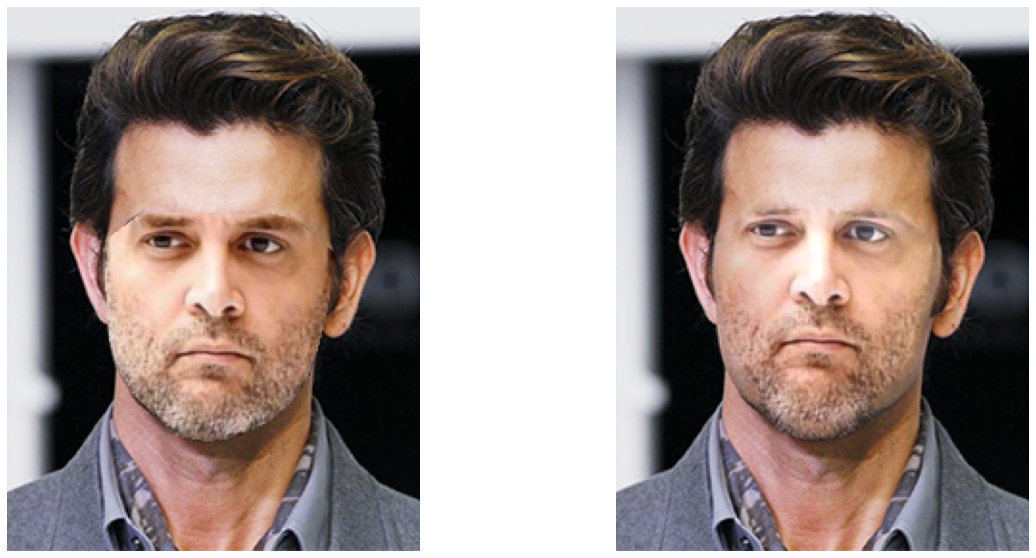

In [77]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');